<a href="https://colab.research.google.com/github/Tharun-selladurai/22csr223/blob/master/ResNet18_%E2%86%92_Autoencoder_%E2%86%92_QGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import zipfile, os

# Step 1: Upload the zip file manually
uploaded = files.upload()  # This will open a file picker

# Step 2: Find the actual uploaded file name
uploaded_filename = list(uploaded.keys())[0]  # Automatically get the uploaded file name
zip_path = f"/content/{uploaded_filename}"
extract_path = "/content/brain_mri_dataset"

# Step 3: Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 4: List extracted contents to verify
print("Extraction complete. Files inside:")
print(os.listdir(extract_path))


Saving archive (2).zip to archive (2).zip
Extraction complete. Files inside:
['yes', 'brain_tumor_dataset', 'no']


Load and Preprocess Images

In [9]:
import os
print(os.listdir('.'))  # List current directory contents

for root, dirs, files in os.walk('.'):
    if 'yes' in dirs and 'no' in dirs:
        print(f"Found dataset folders at: {root}")
        break


['.config', 'tsne_resnet18_features.png', 'sample_data']


Feature Extraction using ResNet18

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


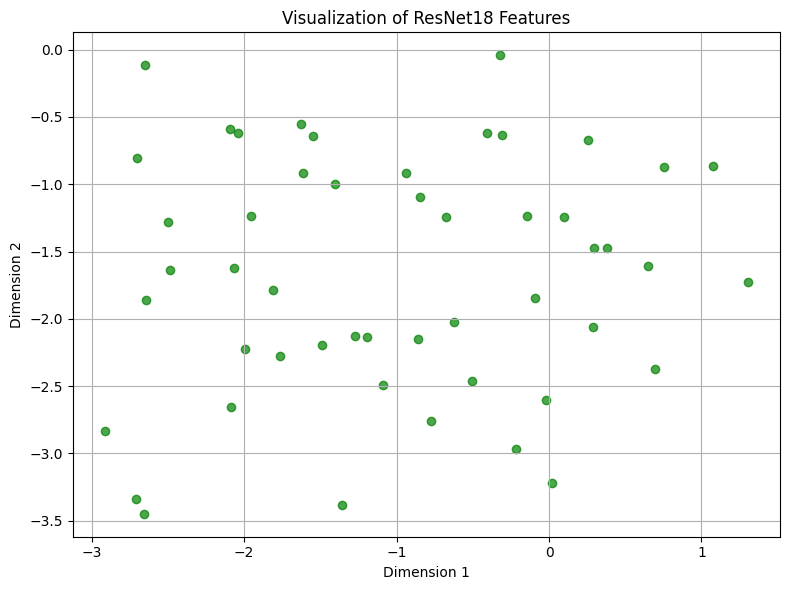

In [10]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define transform for ResNet18
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load pretrained ResNet18
resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()
resnet.eval()

# Simulate grayscale image data (50 images of 224x224)
np.random.seed(42)
all_images = np.random.randint(0, 256, (50, 224, 224), dtype=np.uint8)

# Extract features
def extract_resnet_features(images):
    features = []
    for img_array in images:
        img_pil = Image.fromarray(img_array)
        img_tensor = transform(img_pil).unsqueeze(0)
        with torch.no_grad():
            feat = resnet(img_tensor).squeeze().numpy()
        features.append(feat)
    return np.array(features)

resnet_features = extract_resnet_features(all_images)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(resnet_features)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c='green', alpha=0.7)
plt.title("Visualization of ResNet18 Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()

# Save the figure in current directory instead of /mnt/data/
plt.savefig("tsne_resnet18_features.png")  # ✅ FIXED
plt.show()



Define and Train the Autoencoder

Epoch 1, Loss: 0.8564
Epoch 2, Loss: 0.7310
Epoch 3, Loss: 0.4734
Epoch 4, Loss: 0.2600
Epoch 5, Loss: 0.1035
Epoch 6, Loss: 0.0668
Epoch 7, Loss: 0.0514
Epoch 8, Loss: 0.0356
Epoch 9, Loss: 0.0247
Epoch 10, Loss: 0.0198
Epoch 11, Loss: 0.0187
Epoch 12, Loss: 0.0158
Epoch 13, Loss: 0.0153
Epoch 14, Loss: 0.0140
Epoch 15, Loss: 0.0136
Epoch 16, Loss: 0.0141
Epoch 17, Loss: 0.0135
Epoch 18, Loss: 0.0135
Epoch 19, Loss: 0.0144
Epoch 20, Loss: 0.0133
Epoch 21, Loss: 0.0126
Epoch 22, Loss: 0.0141
Epoch 23, Loss: 0.0131
Epoch 24, Loss: 0.0146
Epoch 25, Loss: 0.0140
Epoch 26, Loss: 0.0124
Epoch 27, Loss: 0.0137
Epoch 28, Loss: 0.0143
Epoch 29, Loss: 0.0137
Epoch 30, Loss: 0.0131
Epoch 31, Loss: 0.0135
Epoch 32, Loss: 0.0140
Epoch 33, Loss: 0.0141
Epoch 34, Loss: 0.0132
Epoch 35, Loss: 0.0131
Epoch 36, Loss: 0.0127
Epoch 37, Loss: 0.0135
Epoch 38, Loss: 0.0126
Epoch 39, Loss: 0.0142
Epoch 40, Loss: 0.0128
Epoch 41, Loss: 0.0126
Epoch 42, Loss: 0.0133
Epoch 43, Loss: 0.0145
Epoch 44, Loss: 0.01

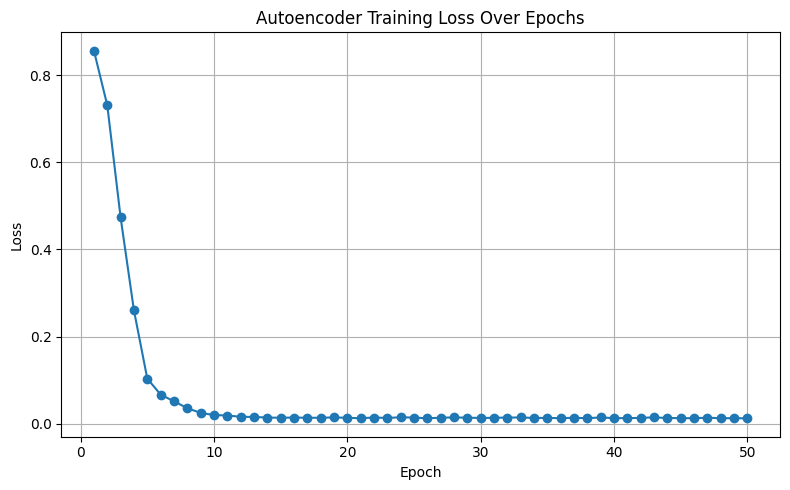

In [11]:
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

# Define the autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        self.decoder = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize model, criterion, optimizer
autoencoder = Autoencoder()
resnet_tensor = torch.tensor(resnet_features, dtype=torch.float32)
train_loader = torch.utils.data.DataLoader(resnet_tensor, batch_size=16, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop with loss recording
epochs = 50
loss_values = []

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        encoded, decoded = autoencoder(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Plotting the loss graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.title("Autoencoder Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


Extract 5D Compressed Features from Encoder

In [14]:

autoencoder.eval()


with torch.no_grad():
    compressed_features = autoencoder.encoder(resnet_tensor).numpy()

print("Compressed feature shape:", compressed_features.shape)


Compressed feature shape: (50, 5)


Build and Train the QGNN (5-qubit Quantum Neural Network)

In [15]:
!pip install pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 101.1 MB/s eta 0:00:00


In [16]:
import pennylane as qml
import torch.nn as nn


n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)


@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    for i in range(n_qubits):
        qml.Rot(*weights[i], wires=i)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


weight_shapes = {"weights": (n_qubits, 3)}


In [25]:

qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)


class QGNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.quantum = qlayer
        self.classifier = nn.Sequential(
            nn.Linear(n_qubits, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.quantum(x)
        return self.classifier(x)


In [28]:
import os
import numpy as np
from PIL import Image
import torch
from sklearn.model_selection import train_test_split

# Step 1: Find dataset folder automatically
def find_dataset_folder(start_dir='.'):
    for root, dirs, files in os.walk(start_dir):
        if 'yes' in dirs and 'no' in dirs:
            return root
    return None

dataset_path = find_dataset_folder()
if dataset_path is None:
    raise FileNotFoundError("Dataset folder with 'yes' and 'no' not found.")

# Step 2: Load images and labels
def load_images(folder, label, size=(64,64)):
    images, labels = [], []
    for fname in os.listdir(folder):
        try:
            img = Image.open(os.path.join(folder, fname)).convert('L').resize(size)
            images.append(np.array(img))
            labels.append(label)
        except:
            pass
    return images, labels

tumor_images, tumor_labels = load_images(os.path.join(dataset_path, 'yes'), 1)
normal_images, normal_labels = load_images(os.path.join(dataset_path, 'no'), 0)

all_images = np.array(tumor_images + normal_images)
all_labels = np.array(tumor_labels + normal_labels)

print("Images shape:", all_images.shape)
print("Labels shape:", all_labels.shape)

# Step 3: Assuming you have your features ready in compressed_features (e.g., output of your autoencoder or extractor)
# For demo, let's assume compressed_features = all_images flattened (replace with your real features)
compressed_features = all_images.reshape(len(all_images), -1)  # Flatten images

# Step 4: Train-test split
X = compressed_features
y = all_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print(f"Training samples: {len(X_train_tensor)}")
print(f"Test samples: {len(X_test_tensor)}")


FileNotFoundError: Dataset folder with 'yes' and 'no' not found.

Train the QGNN Model

In [29]:
import matplotlib.pyplot as plt

model = QGNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 20
loss_values = []
accuracy_values = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for i in range(len(X_train_tensor)):
        x_sample = X_train_tensor[i]
        y_sample = y_train_tensor[i].unsqueeze(0)

        optimizer.zero_grad()
        output = model(x_sample).unsqueeze(0)
        loss = criterion(output, y_sample)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = (output > 0.5).float()
        correct += (pred == y_sample).sum().item()

    avg_loss = total_loss / len(X_train_tensor)
    acc = correct / len(X_train_tensor)

    loss_values.append(avg_loss)
    accuracy_values.append(acc)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={acc*100:.2f}%")

# Plot Loss and Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), loss_values, marker='o', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), [a * 100 for a in accuracy_values], marker='o', color='green')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()


NameError: name 'X_train_tensor' is not defined